In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Wed Dec 25 15:30:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import zipfile
!unzip '/content/drive/MyDrive/Colab Notebooks/masoume/emotions.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/masoume/emotions.zip
   creating: emotions/
  inflating: emotions/fer2013.csv    
   creating: emotions/fer2013/
  inflating: emotions/fer2013/fer2013.csv  


In [ ]:
import pandas as pd

df = pd.read_csv('emotions/fer2013.csv')
df

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [ ]:
df['Usage'].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [ ]:
import numpy as np
import math


def str2img(x):
  data = np.array([int(val) for val in x.split()])
  dimention = int(math.sqrt(len(data)))
  data = data.reshape(dimention, dimention)
  return data


y_train = df.loc[df['Usage'] == 'Training', 'pixels']
y_train = np.stack(y_train.apply(str2img), axis=0)

y_valid = df.loc[df['Usage'] == 'PrivateTest', 'pixels']
y_valid = np.stack(y_valid.apply(str2img), axis=0)

y_test = df.loc[df['Usage'] == 'PublicTest', 'pixels']
y_test = np.stack(y_test.apply(str2img), axis=0)

y_train.shape, y_valid.shape, y_test.shape

((28709, 48, 48), (3589, 48, 48), (3589, 48, 48))

At first, we define x_train, x_valid and x_test as the main images, Next we apply a noise like poisson noise on those images on x_train, x_valid and x_test data.

In [ ]:
import cv2 as cv
mean=0
sigma=10

def add_poisson_noise(img):
    image = img.copy()
    noisy_image = np.random.poisson(image).astype('float32')
    noisy_image = np.clip(noisy_image, 0, 255)
    return noisy_image

x_train = np.array([add_poisson_noise(img) for img in y_train])
x_valid = np.array([add_poisson_noise(img) for img in y_valid])
x_test = np.array([add_poisson_noise(img) for img in y_test])

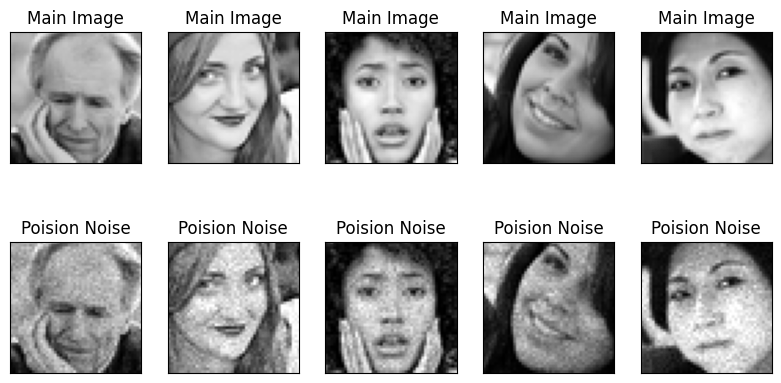

In [ ]:
import matplotlib.pyplot as plt

np.random.seed(48)

indices = np.random.randint(0, y_test.shape[0], size=5)

fig = plt.figure(figsize=(20, 5))

for i, index in enumerate(indices):
  plt.subplot(2, 10, i + 1, xticks=[], yticks=[])
  plt.imshow(y_test[index], cmap=plt.cm.binary_r), plt.title('Main Image')
for i, index in enumerate(indices):
  plt.subplot(2, 10, i + 11, xticks=[], yticks=[])
  plt.imshow(x_test[index], cmap=plt.cm.binary_r), plt.title('Poision Noise')

plt.show()

In [ ]:
x_train = x_train / 255.0
x_valid = x_valid / 255.0
x_test = x_test / 255.0
y_train = y_train / 255.0
y_valid = y_valid / 255.0
y_test = y_test / 255.0

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

inputs = tf.keras.Input(shape=(48, 48, 1))

# Encoder
encoder_block1_conv1 = layers.Conv2D(32, 1, activation='relu', padding='same')(inputs)
encoder_block1_conv2 = layers.Conv2D(32, 1, activation='relu', padding='same')(encoder_block1_conv1)
encoder_block1_pool = layers.MaxPooling2D(pool_size=(2, 2))(encoder_block1_conv2)

encoder_block2_conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(encoder_block1_pool)
encoder_block2_conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(encoder_block2_conv1)
encoder_block2_pool = layers.MaxPooling2D(pool_size=(2, 2))(encoder_block2_conv2)

encoder_block3_conv1 = layers.Conv2D(128, 3, activation='relu', padding='same')(encoder_block2_pool)
encoder_block3_conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(encoder_block3_conv1)
encoder_block3_pool = layers.MaxPooling2D(pool_size=(2, 2))(encoder_block3_conv2)

# Bottleneck
bottleneck_conv1 = layers.Conv2D(256, 3, activation='relu', padding='same')(encoder_block3_pool)
bottleneck_conv2 = layers.Conv2D(256, 3, activation='relu', padding='same')(bottleneck_conv1)

# Decoder
decoder_block1_upsample = layers.UpSampling2D(size=(2, 2))(bottleneck_conv2)
decoder_block1_concat = layers.Concatenate()([decoder_block1_upsample, encoder_block3_conv2])
decoder_block1_conv1 = layers.Conv2D(128, 3, activation='relu', padding='same')(decoder_block1_concat)
decoder_block1_conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(decoder_block1_conv1)

decoder_block2_upsample = layers.UpSampling2D(size=(2, 2))(decoder_block1_conv2)
decoder_block2_concat = layers.Concatenate()([decoder_block2_upsample, encoder_block2_conv2])
decoder_block2_conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(decoder_block2_concat)
decoder_block2_conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(decoder_block2_conv1)

decoder_block3_upsample = layers.UpSampling2D(size=(2, 2))(decoder_block2_conv2)
decoder_block3_concat = layers.Concatenate()([decoder_block3_upsample, encoder_block1_conv2])
decoder_block3_conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(decoder_block3_concat)
decoder_block3_conv2 = layers.Conv2D(32, 3, activation='relu', padding='same')(decoder_block3_conv1)

# Output layer
outputs = layers.Conv2D(1, 1, activation=None)(decoder_block3_conv2)

model = models.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 48, 48, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 48, 48, 32)     │             64 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 48, 48, 32)     │          1,056 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 24, 24, 32)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 24, 24, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 24, 24, 64)     │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 12, 12, 64)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 12, 12, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 12, 12, 128)    │        147,584 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 6, 6, 128)      │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 6, 6, 256)      │        295,168 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 6, 6, 256)      │        590,080 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 12, 12, 256)    │              0 │ conv2d_7[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 12, 12, 384)    │              0 │ up_sampling2d[0][0],   │
│                           │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 12, 12, 128)    │        442,496 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 12, 12, 128)    │        147,584 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 24, 24, 128)    │              0 │ conv2d_9[0][0]         │
│ (UpSampling2D)       

 Total params: 1,937,857 (7.39 MB)

 Trainable params: 1,937,857 (7.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
checkpoint_filename = 'best_denoising_weights.keras'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse'])

history = model.fit(
  x_train,
  y_train,
  epochs=20,
  batch_size=32,
  validation_data=(x_valid, y_valid),
  callbacks=[early_stop, model_checkpoint],
  verbose=1
)

Epoch 1/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0325 - mae: 0.0938 - mse: 0.0325
Epoch 1: val_loss improved from inf to 0.00119, saving model to best_denoising_weights.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - loss: 0.0325 - mae: 0.0938 - mse: 0.0325 - val_loss: 0.0012 - val_mae: 0.0259 - val_mse: 0.0012
Epoch 2/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0011 - mae: 0.0247 - mse: 0.0011
Epoch 2: val_loss improved from 0.00119 to 0.00096, saving model to best_denoising_weights.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 0.0011 - mae: 0.0247 - mse: 0.0011 - val_loss: 9.6471e-04 - val_mae: 0.0236 - val_mse: 9.6471e-04
Epoch 3/20
896/898 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 9.4553e-04 - mae: 0.0234 - mse: 9.4553e-04
Epoch 3: val_loss improved from 0.00096 to 0.00089, saving model to best_denoising_weights.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 9.4546e-04 - mae: 0.0234 - mse: 9.4546e-04 - val_loss: 8.8606e-04 - val_mae:

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


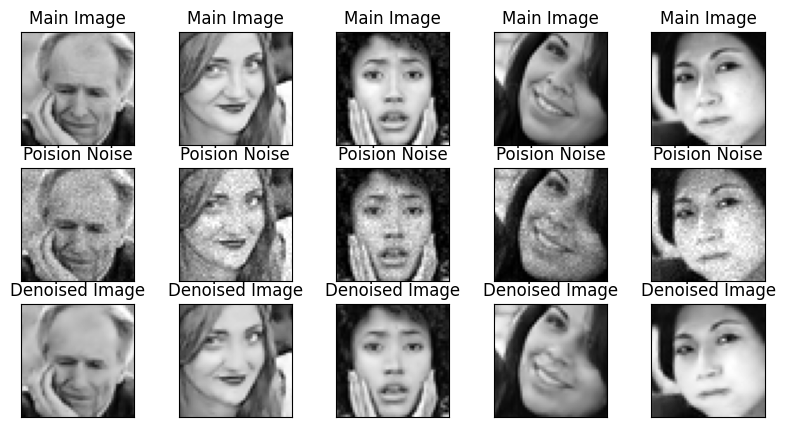

In [ ]:
model_output = model.predict(x_test)

np.random.seed(48)

indices = np.random.randint(0, y_test.shape[0], size=5)

fig = plt.figure(figsize=(20, 5))

for i, index in enumerate(indices):
  plt.subplot(3, 10, i + 1, xticks=[], yticks=[])
  plt.imshow(y_test[index], cmap=plt.cm.binary_r), plt.title('Main Image')
for i, index in enumerate(indices):
  plt.subplot(3, 10, i + 11, xticks=[], yticks=[])
  plt.imshow(x_test[index], cmap=plt.cm.binary_r), plt.title('Poision Noise')
for i, index in enumerate(indices):
  plt.subplot(3, 10, i + 21, xticks=[], yticks=[])
  plt.imshow(model_output[index], cmap=plt.cm.binary_r), plt.title('Denoised Image')

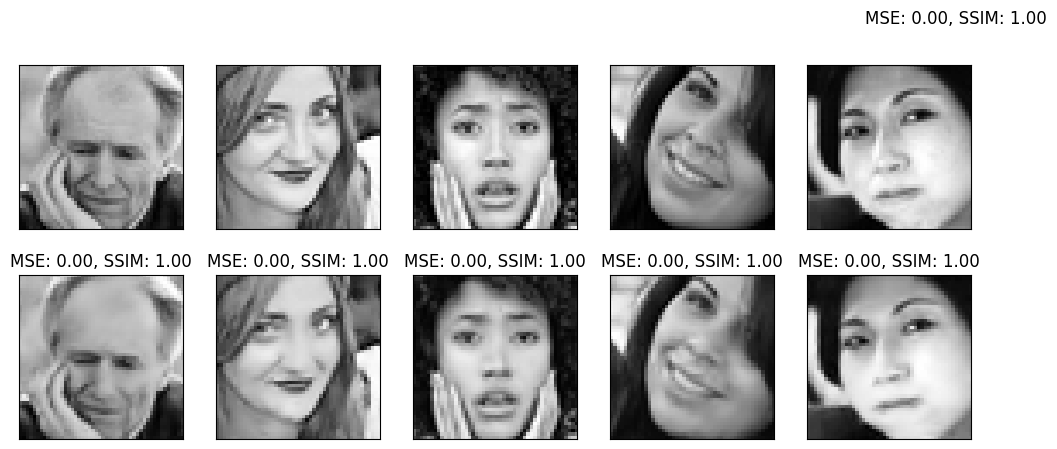

In [ ]:
fig = plt.figure(figsize=(25, 5))

for i, index in enumerate(indices):
  m = mse(y_test[sample].reshape(48, 48, 1), model_output[sample])
  s = ssim(y_test[sample].astype(np.uint8), model_output[sample][:, :, 0].astype(np.uint8))

  plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s))

  plt.subplot(2, 10, i + 1, xticks=[], yticks=[])
  plt.imshow(y_test[index], cmap=plt.cm.binary_r)

  plt.subplot(2, 10, i + 11, xticks=[], yticks=[])
  plt.imshow(model_output[index], cmap=plt.cm.binary_r), plt.title("MSE: %.2f, SSIM: %.2f" % (m, s))

plt.show()

In [ ]:
m = 0
s = 0

for actual, denoised in zip(y_test, model_output):
  m = m + mse(actual.reshape(48, 48, 1), denoised)
  s = s + ssim(actual.astype(np.uint8), denoised[:, :, 0].astype(np.uint8))

m = m / len(y_test)
s = s / len(y_test)

print("MSE: %.5f, SSIM: %.5f" % (m, s))

MSE: 0.00064, SSIM: 0.99966
